In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

## Analisis descriptivo: Puntos de venta
Con las técnicas de clustering, tratamos de encontrar algún patrón en los datos correspondientes al preprocesamiento de los puntos de venta realizados en [02-analisis-exploratorio-pos.ipynb](./02-analisis-exploratorio-pos.ipynb).

Con la librería de sklearn utilizamos el algoritmo Kmeans. 
Se realizan las 2 métricas utilizadas en clase: silhoueutte y davies bouldin.

Recordamos que: 
- **silhouette** es una métrica donde los valores van de -1 a 1. Los valores cercanos a -1 nos dicen que el clustering es incorrecto, +1 nos dicen que el cluster denso y valores alrededor de 0 nos dice que los clusters se solapan. 

- **Davis Bouldin** es una métrica que se espera que nos de un valor cercano a 0, lo que indica que una partición es "buena".

sklearn posee dos implementaciones de K-medias: 
kmeans y MiniBatchKmeans. La diferencia es que minibatch realiza trabajos de performance para mejorar el tiempo de respuesta.

In [10]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics


In [4]:
df_pos = pd.read_parquet('../data/interim/02-pos.parquet')
df_pos.head()

,competidores,ingreso_mediana,densidad_poblacional,pct_bachelors,pct_secundario,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar,SIN VENTAS,POCAS,MEDIO,MUCHAS,pct_0a14,pct_15a39,pct_40a59,pct_60aInf,sin_datos_estudios,pct_posgrado,transporte_sin_datos
id_pos,,,,,,,,,,,,,,,,,,,,,,
288.0,28.686117,55984.323314,11529.97762,18.458126,28.307037,0.590323,2.203479,1.435632,0.157035,3.753466,220923.326912,1,0,0,0,18.123892,34.348226,26.104323,21.423842,43.936427,9.298410,91.860065
953.0,10.000000,43335.606670,10802.09333,19.353333,21.166667,2.800000,3.443333,0.006667,0.030000,10.393333,183392.660000,1,0,0,0,14.443333,47.066667,21.876667,16.600000,43.403333,16.076667,83.326667
1004.0,4.000000,56266.780000,1484.12000,17.050000,35.900000,0.000000,0.000000,0.000000,0.150000,1.680000,164970.870000,1,0,0,0,19.440000,33.550000,28.330000,18.690000,40.790000,6.260000,98.170000
1488.0,1.000000,55410.455000,1699.85500,16.480000,30.045000,0.000000,0.940000,0.000000,0.000000,0.635000,144840.550000,1,0,0,0,22.385000,38.060000,24.390000,15.175000,43.815000,9.660000,98.425000
3171.0,2.000000,30054.200000,18017.32000,7.440000,34.050000,0.000000,17.780000,0.010000,0.250000,0.850000,65605.320000,1,0,0,0,19.920000,33.400000,27.290000,19.370000,55.600000,2.910000,81.110000


In [5]:
X = df_pos.dropna(axis=0)

Reescalamos los datos dado que kmeans trabaja con distancias y esto puede llegar a perjudicar a nuestro algoritmo.

In [6]:
X = MinMaxScaler().fit_transform(X)

Creamos un dataframe que tiene de columnas: k clustes, indice de silhoeutte y davies; allí acumulamos los resultados. 

En primera instancia intentamos generar clusters con todas las caracteristicas.

In [35]:
def execute_algorithm(get_clustering, X):
    df = pd.DataFrame(columns=["K","silhoeutte", "davies"])
    clus = []
    for i in range(2,20):
        # clustering = DBSCAN(eps=0.2, min_samples=2).fit(X)
        clu = get_clustering(i, X)
        labels = clu.labels_
        series = [
            pd.Series(
                {
                    "K":i, 
                    "silhoeutte": metrics.silhouette_score(X, labels, metric='euclidean'), 
                    "davies": metrics.davies_bouldin_score(X, labels)
                }
            )
        ]
        df = df.append(series, ignore_index=True)
        clus.append(clu)
    return df, clus


CPU times: user 11.8 s, sys: 6.67 s, total: 18.5 s
Wall time: 7.73 s


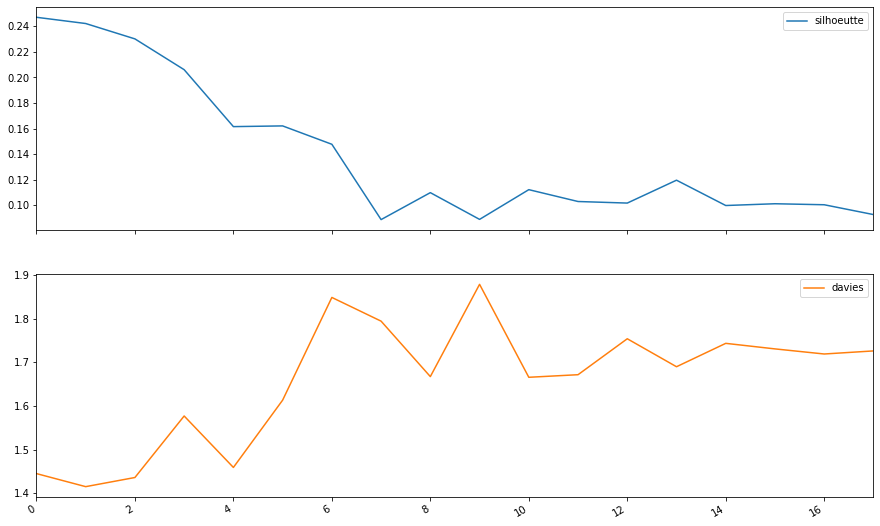

In [22]:
%%time
df, clu = execute_algorithm(lambda i,X: MiniBatchKMeans(n_clusters=i, random_state=1).fit(X), X)
df[["silhoeutte", "davies"]].plot.line(subplots=True, figsize=(15,10))
plt.savefig('../reports/figures/04-line-minibatchkmeans-silhouette_davies.svg')

CPU times: user 38.9 s, sys: 23.9 s, total: 1min 2s
Wall time: 20.2 s


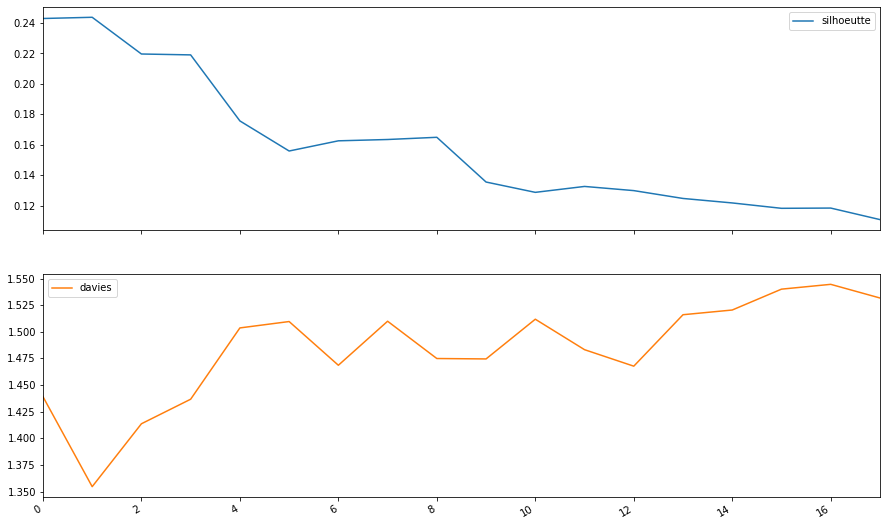

In [23]:
%%time
df, clu = execute_algorithm(lambda i,X: KMeans(n_clusters=i, random_state=1).fit(X), X)
df[["silhoeutte", "davies"]].plot.line(subplots=True, figsize=(15,10))
plt.savefig('../reports/figures/04-line-kmeans-silhouette_davies.svg')

Intentamos realizar un kmedias con los que tienen mayo cantidad de ventas: 

In [13]:
df_pos.columns

Index(['competidores', 'ingreso_mediana', 'densidad_poblacional',
       'pct_bachelors', 'pct_secundario', 'pct_bicicleta', 'pct_omnibus',
       'pct_subtes', 'pct_taxi', 'pct_caminata', 'mediana_valor_hogar',
       'SIN VENTAS', 'POCAS', 'MEDIO', 'MUCHAS', 'pct_0a14', 'pct_15a39',
       'pct_40a59', 'pct_60aInf', 'sin_datos_estudios', 'pct_posgrado',
       'transporte_sin_datos'],
      dtype='object')

In [24]:
X = df_pos[lambda df: df.MUCHAS == 1].drop(['SIN VENTAS', 'POCAS', 'MEDIO', 'MUCHAS'], axis=1)
X = MinMaxScaler().fit_transform(X)

CPU times: user 38.6 s, sys: 24.3 s, total: 1min 2s
Wall time: 20.5 s


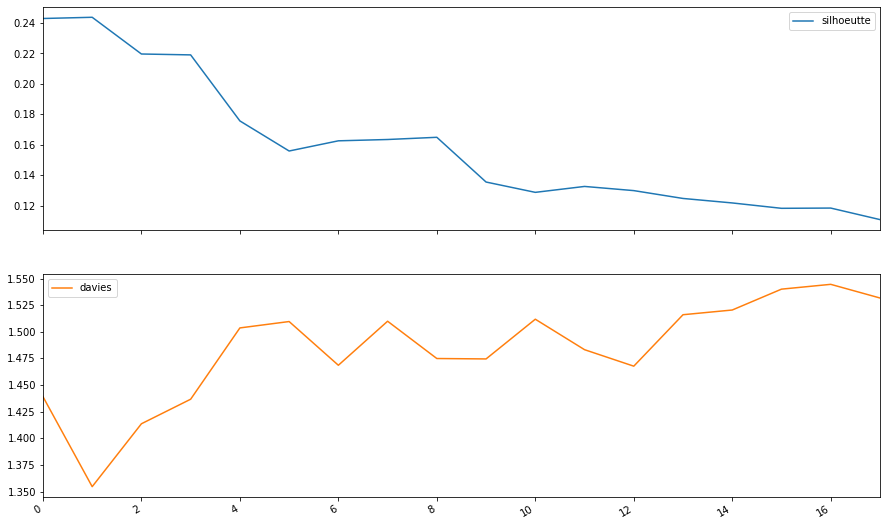

In [25]:
%%time
df, clu = execute_algorithm(lambda i,X: KMeans(n_clusters=i, random_state=1).fit(X), X)
df[["silhoeutte", "davies"]].plot.line(subplots=True, figsize=(15,10))
plt.savefig('../reports/figures/04-line-minibatchkmeans-MUCHAS-ventas-silhouette_davies.svg')

Al agrupar por todas las características solo los puntos de ventas que tienen MUCHAS ventas, no parecen darnos clusters bien formados

In [78]:
X = df_pos[['ingreso_mediana','competidores','densidad_poblacional']]
X = MinMaxScaler().fit_transform(X)

CPU times: user 1min 30s, sys: 36.1 s, total: 2min 6s
Wall time: 1min 6s


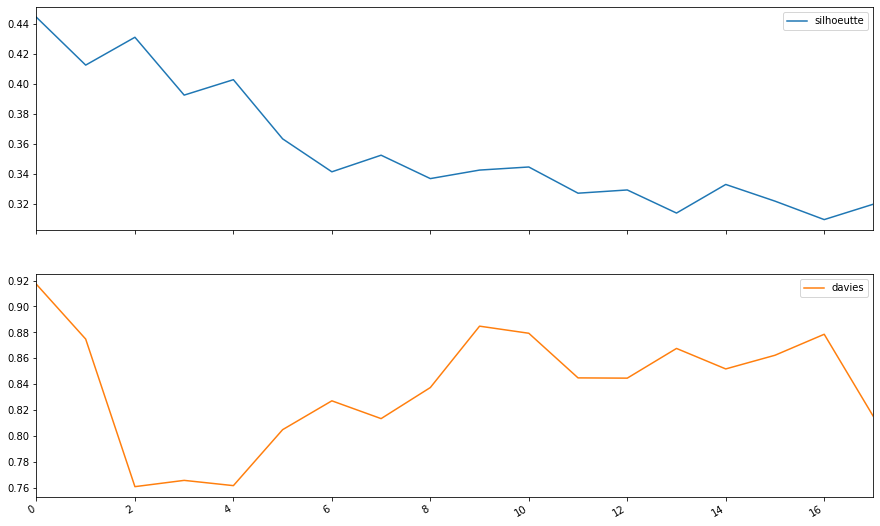

In [40]:
%%time
df, clu = execute_algorithm(lambda i,X: KMeans(n_clusters=i, random_state=1).fit(X), X)
df[["silhoeutte", "davies"]].plot.line(subplots=True, figsize=(15,10))
plt.savefig('../reports/figures/04-line-minibatchkmeans-MUCHAS-ventas-silhouette_davies.svg')

Podríamos intentar gráficar los clusters para cada punto correspondiente: 

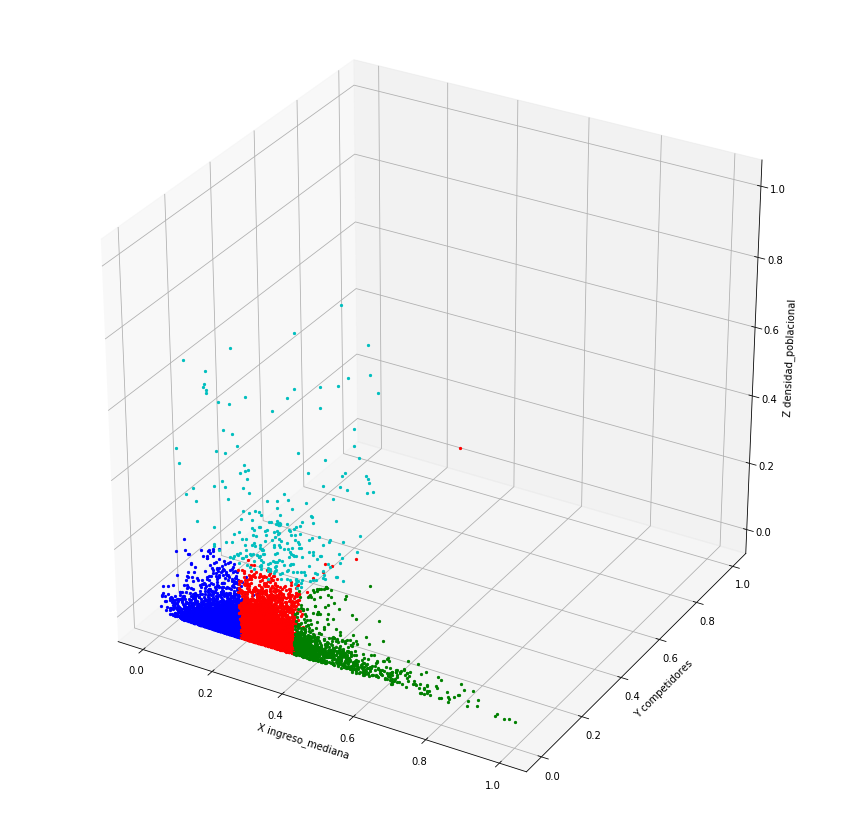

<Figure size 432x288 with 0 Axes>

In [105]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

n = 100

for c,i in zip(clu[2].cluster_centers_,["r","b","g","c"]):
    ax.scatter(c[0],c[1],c[2], c=i)
    
for c,l in zip(X, clu[2].labels_):
    color = ["r","b","g","c"][l]
    ax.scatter(c[0],c[1],c[2], c=color, marker=".")

ax.set_xlabel('X ingreso_mediana')
ax.set_ylabel('Y competidores')
ax.set_zlabel('Z densidad_poblacional')

# plt.figure()
plt.show()
plt.savefig('../reports/figures/04-scatter-kmens.svg')

In [106]:
fig.savefig('../reports/figures/04-scatter-kmens.svg')